# Tutorial 4 - Trace-based Attacks

This tutorial covers:
    
- A summary DCA-style (trace-based) attacks
- How to run them using provided basic implementations

## Basic Framework
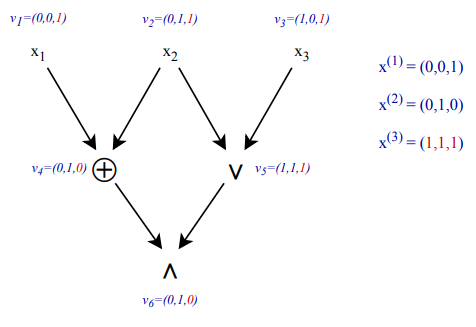

We consider $T$ traces of $N$ functions (on the example, $T=3$, $N=6$).
They are arranged in a **matrix** $V$, each *row* corresponding to one *trace*, and each *column* corresponding to one computed *function* (across all $T$ inputs):

$$V = \pmatrix{v_1 &|& v_2 &|& v_3 &|& \ldots &|& v_N}$$

We target the 1st round of the AES block cipher. More concretely, we focus on *"finding"* an output bit of a chosen S-box $S(x_i \oplus k_i)$ in the white-box implementation. Here, "bit" means "a function" of the input $x$. As this function also depends on the subkey byte $k_i$, we will consider all possible values of this byte.

*"Finding"* means different things in the three attacks we consider: exact matching, correlation (DCA) and linear algebraic attack (LDA).

**Remark**: instead of considering one of the 8 direct output bits, it is also beneficial to consider all/some of their 255 linear (XOR) combinations.

## Exact Matching Attack

The exact matching attack simply attempts to match the guessed function **precisely** on **all** considered inputs. Thus, it can only break an unprotected or implementation.

It can be implemented very efficiently:
1. Evaluate all guessed functions and put them in a hash-set: $D = \{s_k\}_k$
2. For each $v_i$ (a column of $V$), check if it is in the set $D$.

Time: $O(T(K+N))$

```sh
$ pypy3 attacks/analyze_exact.py -h
usage: analyze_exact.py [-h] [-T N_TRACES] [-w WINDOW] [--step STEP] [--masks MASKS] [-o ORDER] trace_dir

Apply "Exact Matching Attack" on pre-recorder traces.

positional arguments:
  trace_dir             path to directory with trace/plaintext/ciphertext files

optional arguments:
  -h, --help            show this help message and exit
  -T N_TRACES, --n-traces N_TRACES
                        number of traces to use in the attack (default: 100)
  -w WINDOW, --window WINDOW
                        sliding window size (default: 2048)
  --step STEP           sliding window step (default: 1024)
  --masks MASKS         linear masks to consider (comma separated ints, or 'all', or 'random16', 'random32') (default: 1,2,4,8,16,32,64,128)
  -o ORDER, --order ORDER
                        attack order (1 or 2) (default: 1)
```

```sh
$ pypy3 attacks/analyze_exact.py tutorials/traces/aes10_clear/
Total traces: 100 of size 3.9K bits (3894)
Using linear masks: (1, 2, 4, 8, 16, 32, 64, 128)
Generated 65536 target vectors
Window 1 / 30
offset 0-2048 (of 31152)
    2048 vectors
    2035 unique vectors
    65536 target vectors
MATCH (SINGLE):
sbox #0,
lin.mask 0x01,
key 0x61='a',
negated? False,
indexes (1 total) [202]

...

Matches (by position): [1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2]
Key candidates found:
S-Box #0: 0x61('a')
...
S-Box #15: 0x48('H')

Example: 61626364656667684142434445464748
```

## Exact Matching Attack (Second-Order)
The attack can be generalized to break low-order linear masking:
$$s = v_i \oplus v_j ~~\Leftrightarrow~~ s \oplus v_i = v_j.$$

1. Put the trace columns $v_j$ in the hash-set $D = V$.
2. For each guessed function $s_k$ and each trace column $v_i$, check if $s_k \oplus v_i$ is in $D$.

Time: $O(T(KN))$

```sh
$ pypy3 attacks/analyze_exact.py tutorials/traces/aes2_isw2/ -o 2 -w 1000000 -s 1000000 --masks 1
Total traces: 100 of size 2.2K bits (2239)
Using linear masks: (1,)
Generated 7680 target vectors
Window 1 / 1
offset 0-17912 (of 17912)
    17912 vectors
    16904 unique vectors
    7680 target vectors
MATCH (DOUBLE):
sbox #1,
lin.mask 0x01,
key 0x62='b',
negated? False,
indexes (1 and 1 total) [2713] [2719]

        [(339, 1)]
        [(339, 7)]

...

Matches (by position): [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Key candidates found:
S-Box #0: 0x61('a')
...
S-Box #15: 0x48('H')

Example: 61626364656667684142434445464748
```

## Correlation Attack (DCA - Differential Computation Analysis)



Correlation attacks relaxes the requirement to **partial** matching. More precisely, the procedure is roughly:

- for each trace vector $v_i \in V$ (a computed function)
  - for each $s_k$ (a guessed function)
    - compute a correlation $v_i \otimes s_k$

A sufficiently high correlation witnesses a likely correct guessed function.

```sh
$ git clone https://github.com/SideChannelMarvels/Daredevil && (cd Daredevil && make)

# combine separate trace files into a single one
# and create a sample config
$ pypy3 attacks/combine4daredevil.py tutorials/traces/aes2_minq/ -T 500
$ cat daredevil.config 

[Traces]
files=1
trace_type=i
transpose=true
index=0
nsamples=122464
trace=tutorials/traces/aes2_minq/all.bin 256 122464

[Guesses]
files=1
guess_type=u
transpose=true
guess=tutorials/traces/aes2_minq/all.input 256 16

[General]
threads=8
order=1
//window=0
return_type=double
algorithm=AES
position=attacks/AES_AFTER_SBOX
round=0
bitnum=0
bytenum=all
//correct_key=???
memory=4G
top=20
```

```sh
$ ./Daredevil/daredevil -c daredevil.config
...

Best 10 candidates for key byte #0 according to sum(abs(bit_correlations)):
 1: 0x61  sum: 0.741072
 2: 0x81  sum: 0.337126
 3: 0xf5  sum: 0.336129
 4: 0xc6  sum: 0.329991
 5: 0xfb  sum: 0.326138
 6: 0x30  sum: 0.321893
 7: 0xb8  sum: 0.321164
 8: 0xd1  sum: 0.311921
 9: 0x83  sum: 0.311904
10: 0x4f  sum: 0.31177

...
```

## Linear Algebraic Attack (LDA - Linear Decoding Analysis)

Recall that traces are arranged in the matrix
$$V = \pmatrix{v_1 &|& v_2 &|& v_3 &|& \ldots &|& v_N}$$

The aim of LDA is to find any amount of intermediate functions that **sum** (XOR) to a given gussed function. This amounts to simply solving the matrix equation
$$V \times z = \pmatrix{s_k(x_1)\\s_k(x_2)\\\vdots\\s_k(x_T)\\}$$

(This has to be done for every guessed function $s_k$, but this can be batched by a precomputation on the matrix $V$)

**Important**: it requires a number of traces $T \ge N + \varepsilon$ for a small integer $\varepsilon$ to avoid false-positives.

On practice, considering a sliding window of $w$ functions $V = \pmatrix{v_i &|& \ldots &|& v_{i+w-1}}$$$.

```sh
$ sage attacks/analyze_linalg_1st.py tutorials/traces/aes2_isw2/ -w 128 --masks 1

...

Window 17 / 557
offset 512-640 (of 17912)
    128 vectors
    126 unique vectors
    8192 target vectors
MATCH:
sbox #0,
lin.mask 0x01,
key 0x61='a',
negated? True,
indexes 65...174 (distance 109) [65, 68, 110, 134, 136, 145, 174]

...

Matches (by position): [28, 25, 26, 30, 28, 28, 29, 26, 26, 24, 30, 27, 27, 22, 30, 28]
Key candidates found:
S-Box #0: 0x61('a')
...
S-Box #15: 0x48('H')

Example: 61626364656667684142434445464748
```

## Conclusions

1. Exact matching attack: very effective against unprotected / low-order masked impl.
2. Correlation attack: can break nonlinear masking with 1 linear share, (dummy) shuffling, CEJO-style implementations.
3. Algebraic attack: can break linear masking with **any number** of shares.

## Exercise

Try to attack different countermeasures (circuits generated in Tutorial 2) with different attacks.

For simplicity, it is sufficient to consider one S-box position, one/few linear masks and small windows.

Attacks on real large white-box implementations however might require more effort (analytical and computational).